In [91]:
# Package import
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import io
from skimage.measure import regionprops
from skimage import data
from skimage.exposure import histogram
from skimage.color import label2rgb
from scipy import ndimage as ndi
import torch
import torch.nn as nn
import math

In [22]:
# Access Manually Identified Bowties
# os.chdir("..")
os.chdir("./npy_raw_data/")
print(os.getcwd()) # Verify that you're in the folder 'npy_raw_data'

c:\Users\aaris\Downloads\Topic 2\Topic 2\npy_raw_data


RANDOM EXPERIMENTATION (DISREGARD, SCROLL DOWN)

[[ 6.3341141e-01  3.1023178e+00  6.3255730e+00 ...  2.5756111e+00
   1.6815186e-02  2.0523224e+00]
 [ 2.8345795e+00  1.9126968e+00  3.4053535e+00 ...  9.3794365e+00
   9.2065392e+00  7.7986717e+00]
 [ 4.1232681e+00  9.1290283e-01  1.1682434e+00 ...  1.7137695e+01
   1.8452797e+01  1.2011360e+01]
 ...
 [-2.4398289e+01 -2.9678055e+01 -2.4859234e+01 ...  1.4814720e+00
   1.3486557e+00 -3.2915688e+00]
 [-2.7704876e+01 -3.7370834e+01 -2.7661751e+01 ...  3.1151505e+00
  -3.1169510e-01 -8.9752350e+00]
 [-2.4344193e+01 -3.4532223e+01 -2.6670368e+01 ...  7.0721016e+00
   2.3824787e+00 -5.6908436e+00]]


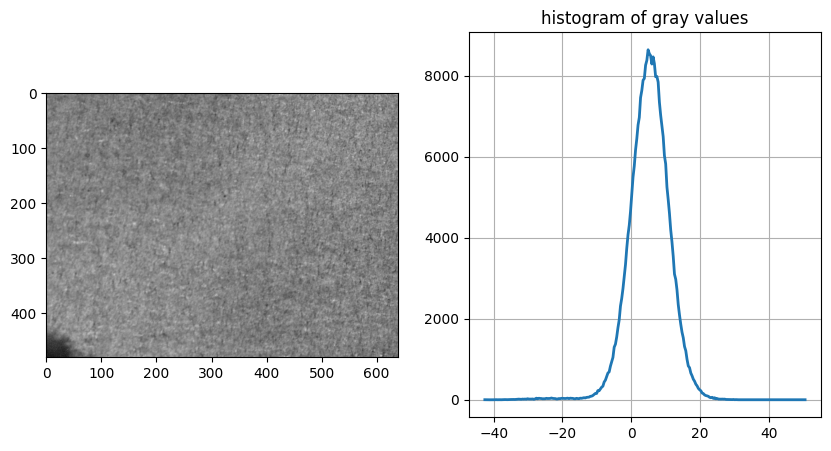

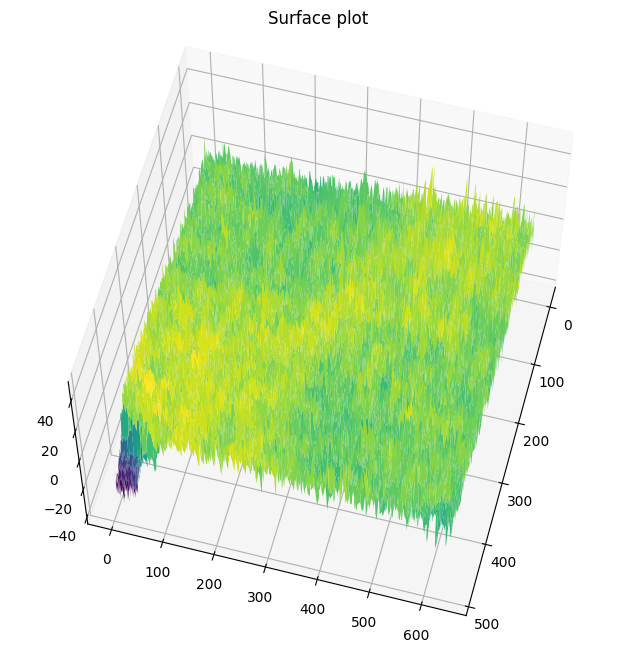

In [34]:
filename = "99_0.npy"

file = np.load(filename)

# Histogram Plot
hist, hist_centers = histogram(file)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(file, cmap='gray')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')
axes[1].grid()

# 3D
Rn = np.shape(file)[0]
Cn = np.shape(file)[1]
x = np.outer(np.arange(Rn), np.ones(Cn))
y = np.outer(np.ones(Rn), np.arange(Cn))
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, file, cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
ax.view_init(60, 15)

SLIDING WINDOW ALGORITHM

In [115]:
# Creates a stacked tensor of shape ([x, 40, 40, 2]) by processing raw image data

# 480 x 640

def slidingWindow(image0, image45, window_length, stride=0):

    lateral = int(len(image0[0])/window_length) # find the amount of columns
    vertical = int(len(image0)/window_length) # find the amount of rows
    
    if stride!=0: # if stride is an input
        divisor = int(window_length/stride) # find the magnitude of difference between stride and window_length

        val = int(math.log(divisor, 2)) # convert this to exponential

        newLateral = lateral
        newVertical = vertical

        # run through 2n-1 calculations (val) amount of times to find the new amount of rows and columns 
        # 2n-1 was derived through experimentation
        for i in range(0, val):
            newLateral = 2*(newLateral) - 1
            newVertical = 2*(newVertical) - 1

        print("\n")
        print("For Dataset with Stride", stride)
        print("Amount of Columns:", newLateral)
        print("Amount of Rows:", newVertical)
        print("\n")

        # establish an empty tensor
        all_data = torch.zeros((newLateral*newVertical, window_length, window_length, 2))

        counter = 0

        # insert data into the tensor by stacking 0 and 45 degree data
        # data is inserted left to right (40x40) with stride included
        # code is also currently configured such that stride is taken into account for row traversing (y direction) as well
        for l in range(0, newLateral):
            for v in range(0, newVertical):
                im0 = image0[stride*v:stride*v+window_length, stride*l:stride*l+window_length]
                im45 = image45[stride*v:stride*v+window_length, stride*l:stride*l+window_length]
                all_data[counter] = torch.from_numpy(np.dstack((im0, im45)))
                counter += 1
    else:
        # establish an empty tensor
        all_data = torch.zeros((lateral*vertical, window_length, window_length, 2))

        counter = 0

        # insert data into the tensor by stacking 0 and 45 degree data
        for l in range(0, lateral):
            for v in range(0, vertical):
                im0 = image0[window_length*v:window_length*(v+1), window_length*l:window_length*(l+1)]
                im45 = image45[window_length*v:window_length*(v+1), window_length*l:window_length*(l+1)]
                all_data[counter] = torch.from_numpy(np.dstack((im0, im45)))
                counter += 1
        
    return all_data

In [116]:
file0 = np.load("99_0.npy")
file45 = np.load("99_45.npy")

# Can leave stride as empty if you want to move 40 pixels at a time
result = slidingWindow(file0, file45, 40, 10) # Note that stride value must be an even divisor of window_length
print("Data tensor shape:", result.shape)
print("\n")
print(result)



For Dataset with Stride 10
Amount of Columns: 61
Amount of Rows: 45


Data tensor shape: torch.Size([2745, 40, 40, 2])


tensor([[[[  0.6334,   5.3570],
          [  3.1023,   7.8700],
          [  6.3256,   6.2556],
          ...,
          [  2.3431,  -1.6056],
          [  1.2706,  -1.5268],
          [  5.2472,   0.9147]],

         [[  2.8346,   3.8861],
          [  1.9127,   6.0013],
          [  3.4054,   4.9017],
          ...,
          [  3.1701,  -0.8365],
          [  4.5325,  -2.9780],
          [  6.6985,  -1.5665]],

         [[  4.1233,   0.5500],
          [  0.9129,   0.4628],
          [  1.1682,   3.6821],
          ...,
          [  8.1968,  -1.1623],
          [  8.5485,  -1.7585],
          [  7.8568,  -3.2737]],

         ...,

         [[  7.2833,   0.7195],
          [  3.2039,   1.5307],
          [  2.1800,   3.1475],
          ...,
          [  0.4226,   0.3907],
          [  2.7951,  -0.9417],
          [  1.4345,  -1.5853]],

         [[  6.8219,   3.4